# Quick start: Fitting the DRT to experimental EIS data

This tutorial gives a quick overview of the process of fitting experimental impedance data, from loading and plotting data to analyzing DRT peaks.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# The line below can be changed to %matplotlib inline or %matplotlib notebook,
# depending on which plotting backend you prefer
%matplotlib inline
from pathlib import Path
import colorsys

import pandas as pd

from hybdrt.models import DRT, DiscreteElementModel
import hybdrt.plotting as hplt
from hybdrt.utils.eis import complex_from_polar
from hybdrt.dataload import read_eis

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and plot spectrum

We load a .mpr file from BioLogic EC-Lab. The loaded spectrum was collected from a solid-state battery comprising NCM-LPSCl composite cathode, LPSCl separator, and InLi alloy counter electrode. 

For more details on loading and visualizing data, see the "Loading and visualizing data" tutorial.

In [19]:
data_path = Path("./data")
file = data_path.joinpath("PEIS_SSB.mpr")

# Load data from .mpr file into a ZData instance
# For more detail on data loading and ZData, see the "Loading and visualizing data" tutorial
zdata = read_eis(file)

# Display the data as a pandas DataFrame
zdata.as_dataframe()

,freq,z_re,z_im,z_mod,z_phase,time
0,7.000018e+06,49.008690,-16.160770,51.604477,-18.250135,6.477496
1,5.553741e+06,53.813301,-16.251560,56.213741,-16.804262,7.326503
2,4.406287e+06,57.878941,-15.754045,59.984676,-15.226440,8.175500
3,3.495908e+06,60.445511,-15.032717,62.286774,-13.966046,9.718494
4,2.773623e+06,63.543625,-14.704953,65.222908,-13.029745,11.400478
...,...,...,...,...,...,...
84,2.525203e-02,2117.034668,-533.937744,2183.329102,-14.155368,455.105464
85,2.001621e-02,2197.014648,-517.153320,2257.060303,-13.245677,560.143060
86,1.587741e-02,2272.732422,-495.068665,2326.028076,-12.288758,692.551767
87,1.260668e-02,2347.594238,-475.183685,2395.203125,-11.442810,859.305432


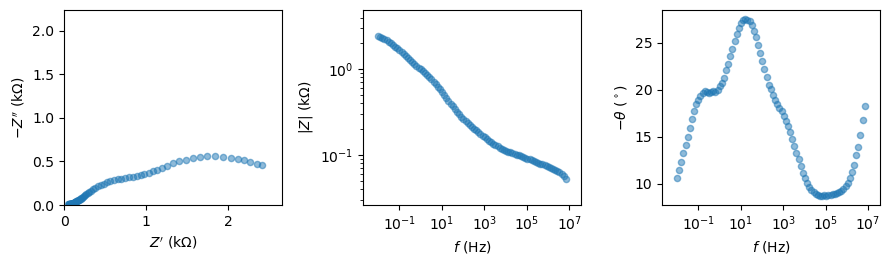

In [20]:
# Plot the spectrum in Nyquist and Bode representations
axes = hplt.plot_eis(zdata)

## Kramers-Kronig test

We first perform a Kramers-Kronig (KK) test to check the validity of the data.

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 50 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')



Identified valid frequency range: 1.0e-02 - 1.7e+06 Hz


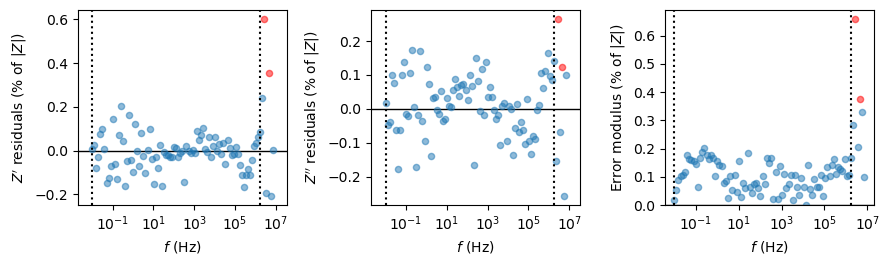

In [21]:
# Create a DRT instance for fitting
drt = DRT()

# Perform a Kramers-Kronig test to identify the valid frequency range of the measurement
# Invalid data points are shown in red
outlier_index, freq_lim, fz_clean = drt.kk_test(*zdata.fx, max_num_outliers=1, show_plot=True)
print("\nIdentified valid frequency range: {:.1e} - {:.1e} Hz".format(freq_lim[0], freq_lim[1]))

The KK test indicates large residuals at high frequencies (>1 MHz). Thus, we should exclude the highest frequencies to avoid perturbation of the estimated DRT.

## Fit the DRT

We can now estimate the DRT from the data. We first fit the full spectrum, including KK-invalid points, for comparison to the fit of the trimmed spectrum.

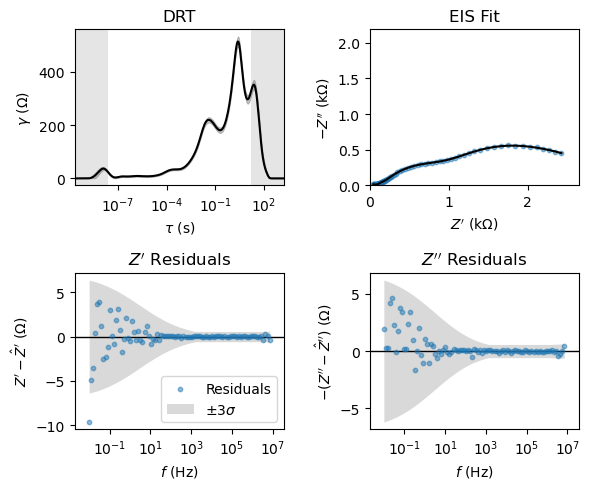

In [22]:
# First, we fit the full spectrum without removing invalid data points
# To fit the EIS data, we need to provide frequency and impedance arrays
# The ZData instance provides attributes freq and z, as well as a convenience attribute fx, which is a tuple of (frequencies, impedances)
drt.fit_eis(*zdata.fx)  # equivalent to drt.fit_eis(zdata.freq, zdata.z)

# Plot a diagnostic summary of the result
drt.plot_results()

# Make a copy of the fitted DRT instance
drt_full = drt.copy()

The diagnostic summary shows the estimated DRT (top left), the fit of the data in the Nyquist plane (top right), and the real and imaginary impedance residuals (bottom row).

In the DRT plot, the grey boundary regions indicate timescale/frequency regions in which the DRT is extrapolated beyond the measured frequency range. This extrapolation is a necessity for fitting spectra in which $Z^\prime$ is not fully relaxed (zero) at the highest or lowest frequencies. However, the extrapolated regions naturally carry higher uncertainty.

In the residual plots, the grey shaded region shows the estimated error structure ($\pm 3 \sigma$ region) of the impedance. There are larger errors at frequencies below 100 Hz, as well as at the highest frequencies above 1 MHz.

Next, we fit the trimmed spectrum for comparison.

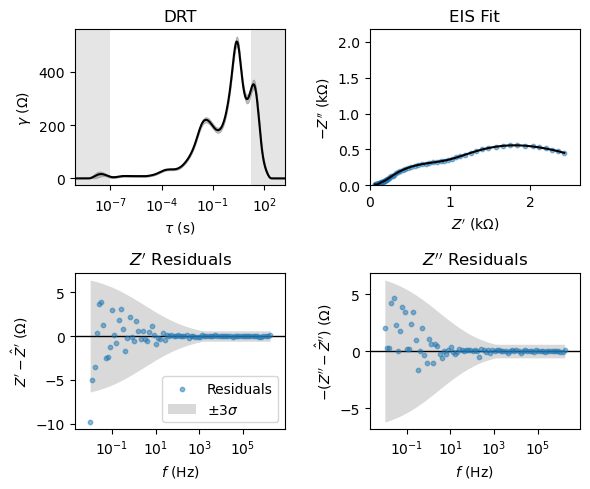

In [23]:
# Fit the KK-trimmed data
# fz_clean is a tuple of (frequencies, impedances)
drt.fit_eis(*fz_clean)

drt.plot_results()

# Make a copy of the fitted DRT instance
drt_clean = drt.copy()

The results from the trimmed spectrum are very similar, but we can see that the erroneous high-frequency points have been removed.

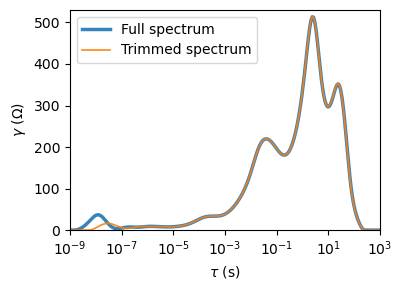

In [24]:
# Compare the DRT results from the full and trimmed spectra
fig, ax = plt.subplots(figsize=(4, 3))

drt_full.plot_drt(ax=ax,label="Full spectrum", lw=2.5, alpha=0.9)
drt_clean.plot_drt(ax=ax, label="Trimmed spectrum", ls="-", alpha=0.9, lw=1.25, c="C1")
ax.set_ylim(0, 530)
ax.set_xlim(1e-9, 1e3)
ax.legend()

Comparing DRTs directly, the only noticeable difference is in the first peak near $\tau \sim 10^{-8}$ s. In the trimmed spectrum, this peak appears smaller and farther to the right (longer time constant) due to the truncation of the data. Because the KK test showed only mild errors and a small frequency range reduction, the effect on the DRT is minor. However, in cases where spectra are more severely perturbed, the difference can be much larger.

## DRT peak analysis

Now that we have a DRT estimate, we can analyze peaks in the DRT to understand what they can tell us about processes occurring in the sample.

We first identify peaks in the DRT using a peak-finding algorithm.

<Axes: xlabel='$\\tau$ (s)', ylabel='$\\gamma$ ($\\Omega$)'>

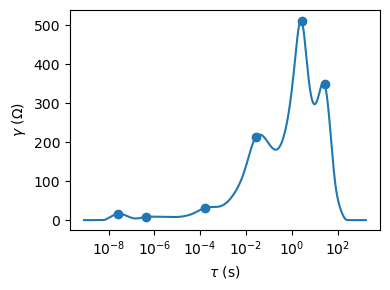

In [25]:
# Find peaks in the distribution using 2nd derivative method
# Set a lower prominence than the default to find the smallest peak
peak_tau = drt_clean.find_peaks(prominence=0.005)

# Plot the DRT with identified peaks marked
drt_clean.plot_drt(mark_peaks=True, mark_peaks_kw=dict(peak_tau=peak_tau))

Next, we can attempt to separate and quantify the peaks. We first do this non-parametrically by splitting the distribution into individual contributions from each identified peak.

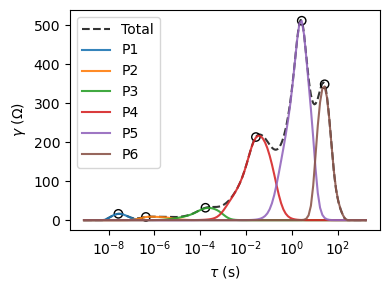

In [26]:
# With the identified peaks, we can split the total DRT into individual peak contributions
# This is a non-parametric deconvolution, so no equivalent circuit model or peak shape is assumed
# Therefore, non-physical peak shapes may arise

# Plot the overall DRT with peaks marked
ax = drt_clean.plot_drt(mark_peaks=True, c="k", alpha=0.8, ls="--", mark_peaks_kw={"facecolors": "none", "edgecolors":"k", "peak_tau": peak_tau}, label="Total")
# Plot the estimated individual peak distributions
drt_clean.plot_peak_drts(ax=ax, alpha=0.9, estimate_peak_drts_kw={"peak_tau": peak_tau}, label="x")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Total"] + [f"P{i + 1}" for i in range(len(peak_tau))])

We can also convert the DRT to an equivalent circuit model by treating each peak as a circuit element. For this example, we use RQ elements (also known as ZARC, R-CPE, or Cole-Cole elements) because most peaks appear to be dispersed and reasonably symmetric. 

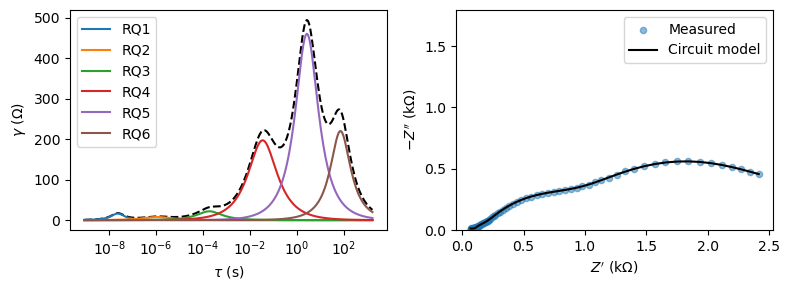

In [27]:
# Create a model based on the identified peaks, using an RQ element to describe each peak
dem = DiscreteElementModel.from_drt(drt_clean, prominence=0.005, drt_element="RQ")
# Fit the model to the data (optimize the peak parameters, which are initialized from the DRT)
dem.fit_eis(*fz_clean, from_drt=False)


fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot the equivalent distribution of the circuit model
tau_plot = drt_clean.get_tau_eval(20)
dem.plot_drt(tau_plot, ls="--", c="k", ax=axes[0])
dem.plot_element_drts(tau_plot, ax=axes[0], kw_list=[{"label": f"RQ{i+1}"} for i in range(dem.num_drt_elements)])

axes[0].legend()

# Plot the circuit model fit of the data
dem.plot_eis_fit(axes=axes[1], label="Circuit model", data_label="Measured")
axes[1].legend()

The circuit model produces an equivalent DRT similar to the original DRT estimate. The circuit model also fits the data well. The advantage of converting the DRT to a circuit model is that we now have well-defined peak shapes and parameters, which may be helpful for interpretation and quantification.